In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [131]:
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import export_graphviz
from subprocess import call
from IPython.display import Image
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

In [3]:
def dtype_compressor(df):
  #object 
  # when unique ratio > 0.5, catogory stands less memory than object
  converted_obj = pd.DataFrame()
  df_obj = df.select_dtypes(include=['object'])
  for col in df_obj.columns:
    converted_obj.loc[:,col] = df_obj.loc[:,col].astype('category')

  # numbers
  df_down_num = pd.DataFrame()
  df_num = df.select_dtypes(include=['number'])
  for col in df_num.columns:
    df_down_num.loc[:,col] = pd.to_numeric(df_num.loc[:,col],downcast='signed')

  # merge
  df = pd.concat([converted_obj,df_down_num],axis=1)
  
  del converted_obj, df_obj, df_down_num, df_num  
  
  return df

In [4]:
def fast_datetime(s):
    dates = {date:pd.to_datetime(date,format='%Y-%m-%d') for date in s.unique()}
    return s.map(dates)

In [5]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

---

### 讀取並觀察資料

In [36]:
KKboxTrainMembersTransac = pd.read_csv('KKboxTrainMembersTransac.csv')

In [37]:
KKboxTrainMembersTransac.head()

,msno,is_churn,city,bd,gender,registered_via,registration_init_time,last_last_churn,last_auto_renew,is_discount,amount_per_day,longtime_user
0,waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y=,1,18,36,0,9,2005-04-06,1,0,2,2.48,0
1,QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=,1,10,38,1,9,2005-04-07,0,1,23,4.99,1
2,QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=,1,10,38,1,9,2005-04-07,0,1,23,4.99,1
3,fGwBva6hikQmTJzrbz/2Ezjm5Cth5jZUNvXigKK2AFA=,1,11,27,0,9,2005-10-16,0,1,10,4.97,0
4,mT5V8rEpa+8wuqi6x0DoVd3H5icMKkE9Prt49UlmK+4=,1,13,23,0,9,2005-11-02,1,0,3,3.11,0


In [38]:
KKboxTrainMembersTransac = dtype_compressor(KKboxTrainMembersTransac)

In [39]:
d = ['registration_init_time']
for col in d:
  KKboxTrainMembersTransac[col] = fast_datetime(KKboxTrainMembersTransac[col])

In [40]:
# one-hot encoding
'''ToDummiesCol = ['city', 'gender', 'registered_via', 'last_last_churn',\
                 'last_auto_renew', 'longtime_user']
KKboxTrainMembersTransac = pd.get_dummies(KKboxTrainMembersTransac, prefix_sep="__",columns=ToDummiesCol)'''

'ToDummiesCol = [\'city\', \'gender\', \'registered_via\', \'last_last_churn\',                 \'last_auto_renew\', \'longtime_user\']\nKKboxTrainMembersTransac = pd.get_dummies(KKboxTrainMembersTransac, prefix_sep="__",columns=ToDummiesCol)'

In [42]:
ToStringCol = ['is_churn', 'city', 'gender', 'registered_via', 'last_last_churn',\
                 'last_auto_renew', 'longtime_user']
for i in ToStringCol:
    KKboxTrainMembersTransac[i] = KKboxTrainMembersTransac[i].astype('str')

In [43]:
KKboxTrainMembersTransac.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 767924 entries, 0 to 767923
Data columns (total 12 columns):
msno                      767924 non-null category
registration_init_time    767924 non-null datetime64[ns]
is_churn                  767924 non-null object
city                      767924 non-null object
bd                        767924 non-null int8
gender                    767924 non-null object
registered_via            767924 non-null object
last_last_churn           767924 non-null object
last_auto_renew           767924 non-null object
is_discount               767924 non-null int16
amount_per_day            767924 non-null float64
longtime_user             767924 non-null object
dtypes: category(1), datetime64[ns](1), float64(1), int16(1), int8(1), object(7)
memory usage: 376.3 MB


In [44]:
KKboxTrainMembersTransac.describe()

,bd,is_discount,amount_per_day
count,767924.00,767924.00,767924.00
mean,29.96,18.68,4.81
std,8.89,8.38,0.59
min,13.00,2.00,0.00
25%,24.00,12.00,4.77
50%,28.00,21.00,4.94
75%,34.00,26.00,4.97
max,99.00,244.00,7.00


---

##### 拆分訓練集與測試集

In [45]:
X = KKboxTrainMembersTransac.iloc[:,3:]
y = KKboxTrainMembersTransac.iloc[:,2]

In [46]:
# from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3, random_state=87)

##### 訓練模型

In [123]:
dtr = tree.DecisionTreeClassifier()

In [124]:
dtr.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [125]:
# 驗證模型準確度
dtr2.score(X=X_train, y=y_train)

0.7709126288726919

##### 預測

In [126]:
y_pred_dtr = dtr.predict(X_test)

##### 驗證

              precision    recall  f1-score   support

           0       0.93      0.95      0.94    206774
           1       0.48      0.38      0.43     23604

   micro avg       0.89      0.89      0.89    230378
   macro avg       0.71      0.67      0.68    230378
weighted avg       0.89      0.89      0.89    230378



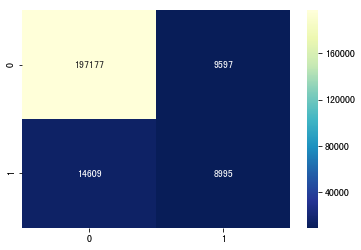

In [128]:
print(metrics.classification_report(y_test, y_pred_dtr))
cm = metrics.confusion_matrix(y_test, y_pred_dtr)
sns.heatmap(cm, cmap="YlGnBu_r", annot=True, fmt="d")
plt.show()

##### 小結：
* 數據不平衡造成模型對於流失(is_churn=1)容易有偏誤(視為噪音等)，故還是需要數據平衡化的資料集進行跑模型

---

---

### 讀取並觀察資料(數據平衡化後)

In [51]:
KKboxTrainMembersTransacBalance = pd.read_csv('KKboxTrainMembersTransacBalance.csv')

In [52]:
KKboxTrainMembersTransacBalance = dtype_compressor(KKboxTrainMembersTransacBalance)

In [53]:
d = ['registration_init_time']
for col in d:
  KKboxTrainMembersTransacBalance[col] = fast_datetime(KKboxTrainMembersTransacBalance[col])

In [54]:
# one-hot encoding
'''ToDummiesCol = ['city', 'gender', 'registered_via', 'last_last_churn',\
                 'last_auto_renew', 'longtime_user']
KKboxTrainMembersTransacBalance = pd.get_dummies(KKboxTrainMembersTransacBalance, prefix_sep="__",columns=ToDummiesCol)'''

'ToDummiesCol = [\'city\', \'gender\', \'registered_via\', \'last_last_churn\',                 \'last_auto_renew\', \'longtime_user\']\nKKboxTrainMembersTransacBalance = pd.get_dummies(KKboxTrainMembersTransacBalance, prefix_sep="__",columns=ToDummiesCol)'

In [55]:
ToStringCol = ['is_churn', 'city', 'gender', 'registered_via', 'last_last_churn',\
                 'last_auto_renew', 'longtime_user']
for i in ToStringCol:
    KKboxTrainMembersTransacBalance[i] = KKboxTrainMembersTransacBalance[i].astype('str')

In [56]:
KKboxTrainMembersTransacBalance.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157237 entries, 0 to 157236
Data columns (total 12 columns):
msno                      157237 non-null category
registration_init_time    157237 non-null datetime64[ns]
is_churn                  157237 non-null object
city                      157237 non-null object
bd                        157237 non-null int8
gender                    157237 non-null object
registered_via            157237 non-null object
last_last_churn           157237 non-null object
last_auto_renew           157237 non-null object
is_discount               157237 non-null int16
amount_per_day            157237 non-null float64
longtime_user             157237 non-null object
dtypes: category(1), datetime64[ns](1), float64(1), int16(1), int8(1), object(7)
memory usage: 83.5 MB


In [57]:
KKboxTrainMembersTransacBalance.describe()

,bd,is_discount,amount_per_day
count,157237.00,157237.00,157237.00
mean,28.94,15.81,4.71
std,8.83,9.41,0.74
min,13.00,2.00,0.00
25%,22.00,7.00,4.56
50%,27.00,17.00,4.94
75%,33.00,23.00,4.97
max,99.00,244.00,7.00


##### 拆分訓練集與測試集

In [58]:
XX = KKboxTrainMembersTransacBalance.iloc[:,3:]
yy = KKboxTrainMembersTransacBalance.iloc[:,2]

In [59]:
XX_train,XX_test,yy_train,yy_test = train_test_split(XX, yy, test_size=0.3, random_state=87)

##### 訓練模型

In [110]:
dtr2 = tree.DecisionTreeClassifier()

In [111]:
dtr2.fit(XX_train, yy_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [112]:
# 驗證模型準確度
dtr2.score(X=XX_train, y=yy_train)

0.9558079316767365

##### 預測

In [115]:
y_pred_dtr2 = dtr2.predict(XX_test)

##### 驗證

In [120]:
print(metrics.classification_report(yy_test, y_pred_dtr2))

              precision    recall  f1-score   support

           0       0.71      0.74      0.72     23675
           1       0.72      0.69      0.71     23497

   micro avg       0.72      0.72      0.72     47172
   macro avg       0.72      0.72      0.72     47172
weighted avg       0.72      0.72      0.72     47172



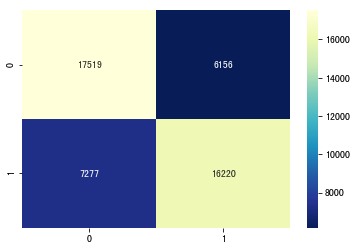

In [129]:
cm = metrics.confusion_matrix(yy_test, y_pred_dtr2)
sns.heatmap(cm, cmap="YlGnBu_r", annot=True, fmt="d")
plt.show()

##### 畫決策樹

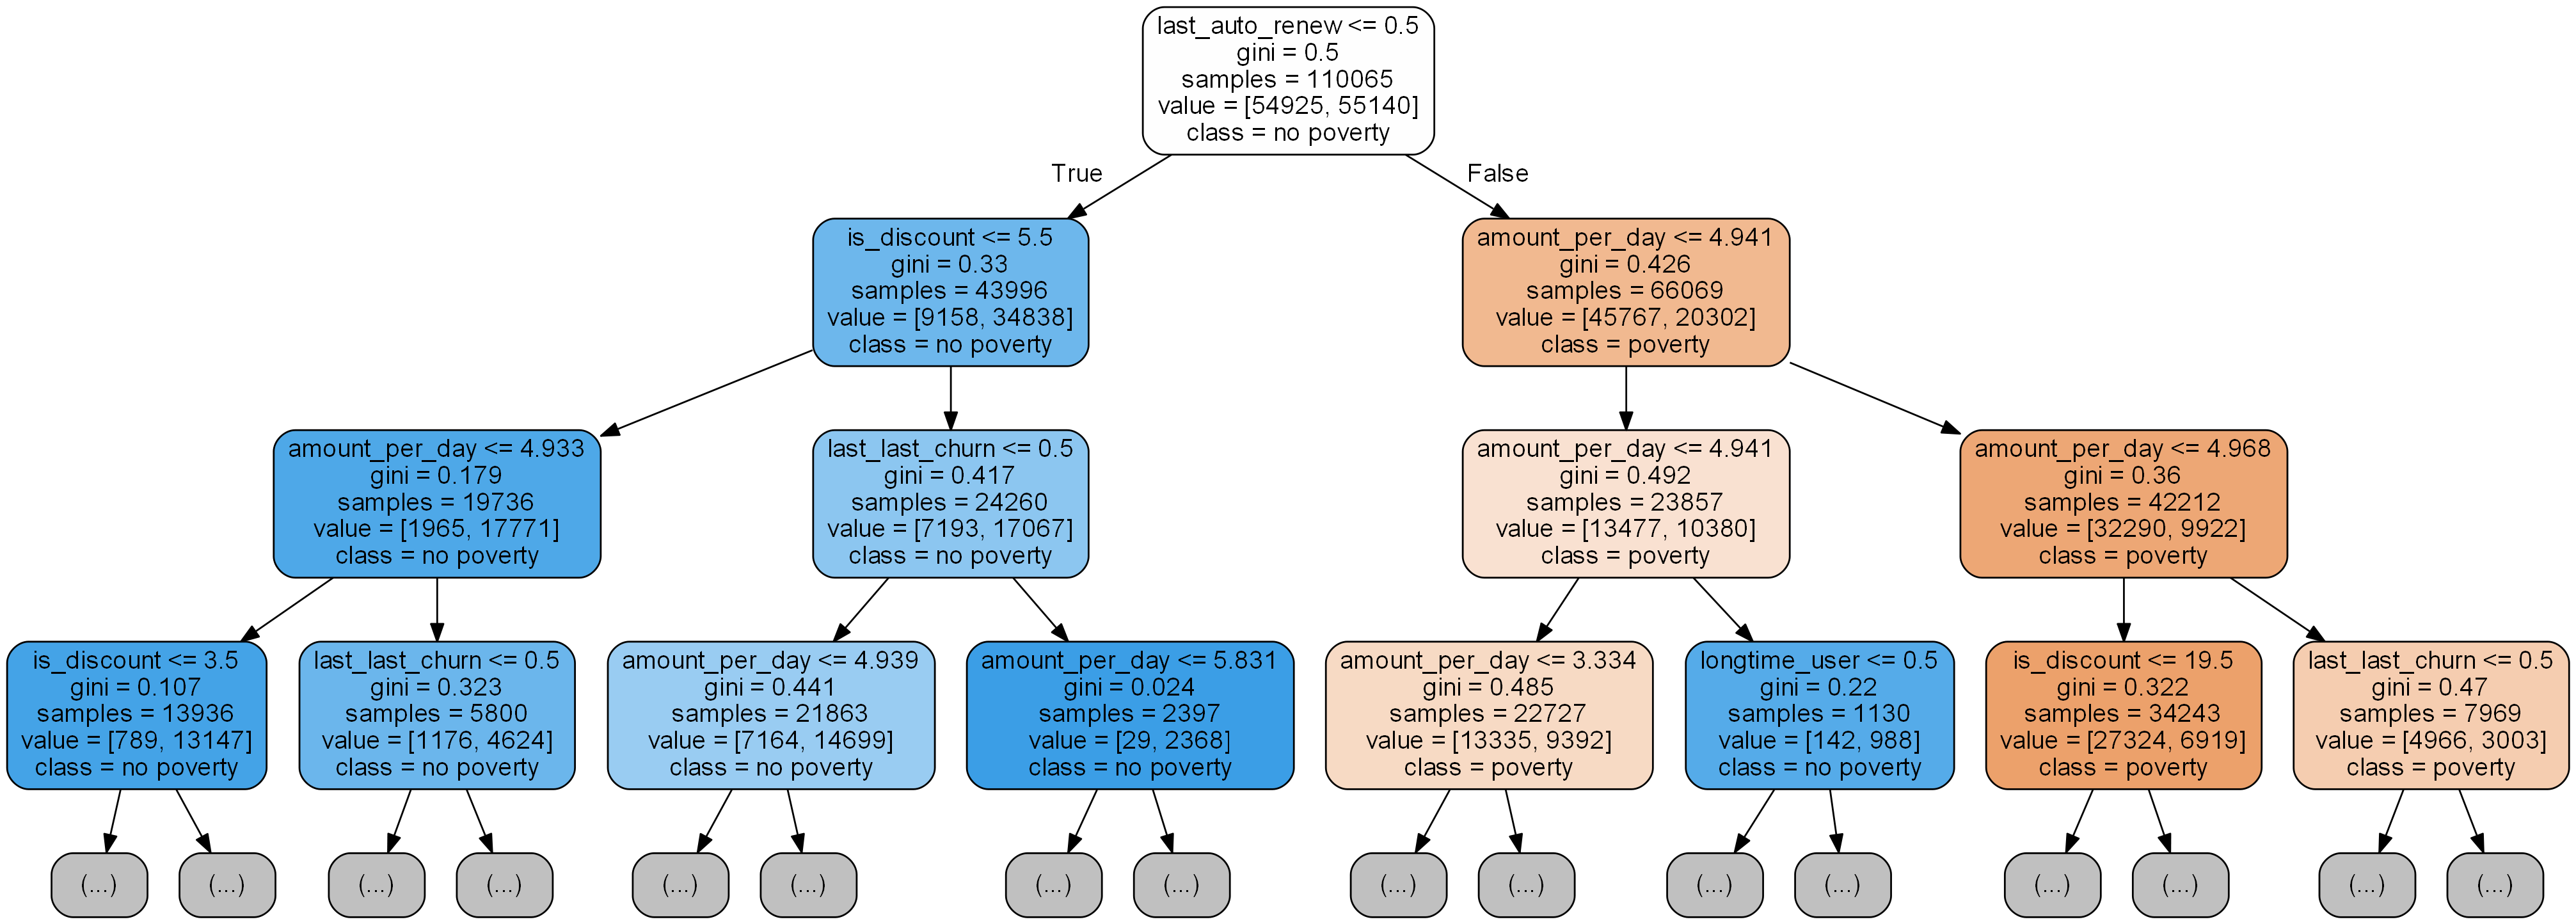

In [133]:
tree.export_graphviz(dtr2, 'tree_from_optimized_forest.dot', rounded = True, 
                feature_names=XX_train.columns, max_depth = 3, 
                class_names = ['poverty', 'no poverty'], filled = True)

call(['dot', '-Tpng', 'tree_from_optimized_forest.dot', '-o', 'tree_from_optimized_forest.png', '-Gdpi=200'])
Image('tree_from_optimized_forest.png')

##### 小結：
* 數據平衡化後的結果可達到較好的混淆矩陣，精確率(precision)與召回率(recall)皆較未處理平衡化數據前好，但仍有提升空間。
* 畫決策樹後發現只用到last_auto_renew, is_discount, amount_per_day以及last_last_churn等四個特徵。